# A Raster Union and More Example

**Goal**: Plot all raster tiles within a radius of a site. 
**Bonus**: Plot all pit locations that fall in the same radius AND dem contours

**Approach**: 

1. Get site location geometry
2. Build a polygon of a circle of X meters radius centered on our pit
3. Grab all raster tiles that intersect our circle, and union them as a tiff. 
4. Build a geopandas dataframe with the pits in the circle. 
5. Plot it!

## Process
### Step 1:

In [10]:
from snowxsql.db import get_db
from snowxsql.data import RasterData, LayerData
from rasterio.plot import show
from sqlalchemy.sql import func
import geoalchemy2.functions as gfunc
from geoalchemy2.shape import to_shape
import geopandas as gpd
from snowxsql.conversions import raster_to_rasterio
from snowxsql.functions import ST_RasterUnion
from snowxsql.conversions import points_to_geopandas, query_to_geopandas
import numpy as np

# PIT Site Identifier
site_id = '5N19'

# Distance around the pit to collect data in meters
buffer_dist = 400

# Connect to the database we made.
db_name = 'postgresql+psycopg2:///snowex'
engine, metadata, session = get_db(db_name)
datasets = []

# Grab our pit layers by site id
q = session.query(LayerData).filter(LayerData.site_id==site_id)
layers = q.all()

### Step 2:

In [11]:
# Grab the pit location from a single layer
p = layers[0].geom
pit = to_shape(p)

# Create a polygon buffered by our distance centered on the pit
q = session.query(gfunc.ST_Buffer(p, buffer_dist))
buffered_pit = q.all()[0][0]
circle = to_shape(buffered_pit)

### Step 3:

In [12]:
# Grab all rasters touching the circle, form a single raster, convert to tiff
rasters = session.query(func.ST_AsTiff(ST_RasterUnion(RasterData.raster))).filter(gfunc.ST_Intersects(RasterData.raster, buffered_pit)).all()

### Step 4:

In [13]:
# Create a geopandas df of layers geometry in the circle
q = session.query(LayerData.geom).filter(gfunc.ST_Within(LayerData.geom, buffered_pit))
nearby_pits = query_to_geopandas(q, engine)

### Step 5: 

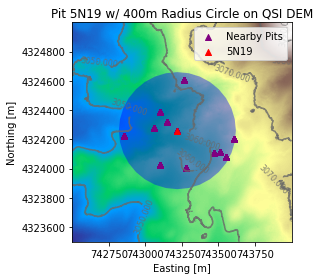

In [15]:
fig, ax = plt.subplots()

dataset = raster_to_rasterio(session, rasters)[0]
img = show(dataset.read(1), ax=ax, transform=dataset.transform, cmap='terrain')
show(dataset.read(1), contour=True, levels=[s for s in np.arange(3000,4000, 10)], colors='dimgray', ax=ax, transform=dataset.transform)

gpd.GeoSeries(circle).plot(ax=ax, color='b', alpha=0.4)

nearby_pits.plot(ax=ax, color='purple', marker='^', label='Nearby Pits')

gpd.GeoSeries(pit).plot(ax=ax, color='r', marker='^', label=site_id)
ax.ticklabel_format(style='plain', useOffset=False)
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_title('Pit {} w/ {}m Radius Circle on QSI DEM'.format(site_id, buffer_dist))
plt.tight_layout()
ax.legend()

dataset.close()
session.close()